# Shapely, Geopandas, and CARTOframes

This notebook demonstrates how to use `cartoframes` with [GeoPandas](http://geopandas.org/), a popular Python package for working with geospatial data in a local environment. It's built on some of the same robust libraries as PostGIS which underlies CARTO's spatial analysis, so compliments CARTO extremely well.

Get started by creating a `CartoContext` that allows you to interact with CARTO in the notebook enviroment.

In [2]:
%matplotlib inline
from cartoframes import CartoContext, Credentials
import geopandas as gpd
import pandas as pd

In [3]:
# set carto credentials
creds = Credentials(key='abcdefg', 
                    username='cartoframes')
creds.save()
cxn = CartoContext()

## Reading and writing data from/to CARTO

To get started, let's use the `nat` dataset which contains county-level criminology data for the United States from 1960 onwards.

In [4]:
# load data into your account
from cartoframes.examples import read_nat

# write `nat` to your CARTO account
cxn.write(read_nat(), 'nat')

# download it and decode geometries
df = cxn.read('nat', decode_geom=True)

Table successfully written to CARTO: https://cartoframes.carto.com/dataset/nat


In [5]:
df.head()

,blk60,blk70,blk80,blk90,cnty_fips,cofips,dnl60,dnl70,dnl80,dnl90,...,state_fips,state_name,stfips,the_geom,the_geom_webmercator,ue60,ue70,ue80,ue90,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,
2367,17.515639,17.566758,13.96325,13.449123,449,449,3.692759,3.687802,3.951113,4.068565,...,48,Texas,48,0106000020E6100000010000000103000000010000000F...,0106000020110F0000010000000103000000010000000F...,4.2,2.7,5.027695,5.863649,(POLYGON ((-94.81377410888672 32.9882507324218...
2148,0.000000,0.007520,0.01176,0.000000,113,113,2.634145,2.739525,2.983983,3.004824,...,5,Arkansas,5,0106000020E6100000010000000103000000010000000F...,0106000020110F0000010000000103000000010000000F...,7.2,5.4,5.717978,5.524099,(POLYGON ((-93.92706298828125 34.3524627685546...
16,0.000000,0.000000,0.00000,0.443038,75,75,1.668175,1.463381,1.417714,1.284332,...,38,North Dakota,38,0106000020E6100000010000000103000000010000000C...,0106000020110F0000010000000103000000010000000C...,4.1,6.0,3.935185,6.328182,(POLYGON ((-101.0608749389648 48.4602966308593...
258,0.000000,0.000000,0.00000,0.000000,49,49,1.484931,1.363188,1.198477,1.009217,...,46,South Dakota,46,0106000020E61000000100000001030000000100000006...,0106000020110F00000100000001030000000100000006...,2.8,0.3,0.539291,1.962388,(POLYGON ((-98.72162628173828 44.8916778564453...
27,0.000000,0.000000,0.00000,0.000000,19,19,0.956364,0.759179,0.686538,0.463073,...,30,Montana,30,0106000020E6100000010000000103000000010000000E...,0106000020110F0000010000000103000000010000000E...,3.7,0.4,2.112676,1.428571,(POLYGON ((-105.8138580322266 48.5703468322753...


By default, CARTO uses Well-known-binary (WKB) serialization for geometries that come out of PostGIS. 

In [5]:
df.head(2)[['fipsno', 'the_geom']]

,fipsno,the_geom
cartodb_id,,
364,27101.0,0106000020E61000000100000001030000000100000007...
1660,20019.0,0106000020E61000000100000001030000000100000006...


These strings can be deserialized into `shapely` objects that work with GeoPandas.

In [6]:
df.head(2)[['fipsno', 'geometry']]

,fipsno,geometry
cartodb_id,,
2367,48449,(POLYGON ((-94.81377410888672 32.9882507324218...
2148,5113,(POLYGON ((-93.92706298828125 34.3524627685546...


This allows you to do GIS operations locally in Geopandas. To send a DataFrame with shapely geometries into a Geopandas DataFrame, you only need to call the constructor directly on the DataFrame:

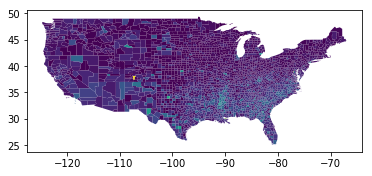

In [7]:
gdf = gpd.GeoDataFrame(df)
gdf.plot('hr90', linewidth=0.1) # to prove we're in geopandas

The nice thing with having the code to serialize/deserialize `shapely` objects is that you can publish directly to CARTO (and make CARTO maps) directly from (geo)pandas:

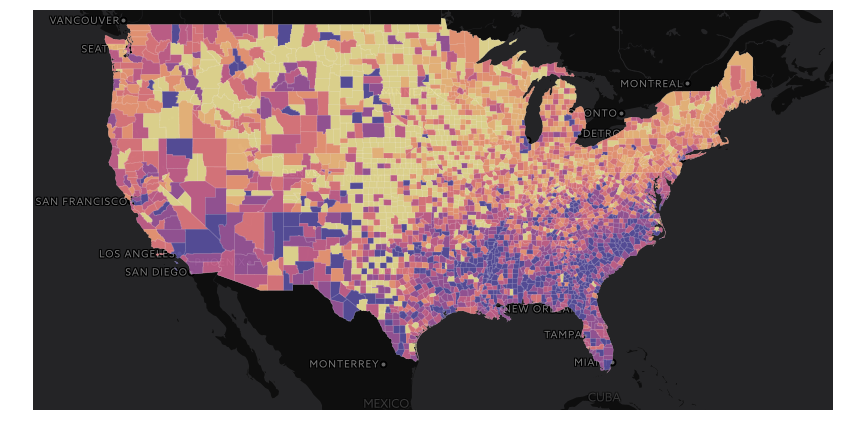

In [8]:
from cartoframes import Layer, styling
cxn.map(layers=Layer('nat', color={'column': 'hr90',
                                   'scheme': styling.sunset(7)}),
        interactive=False)

You can also create interactive versions of the above map by setting `interactive=True`.

**Note:** If viewing this notebook on GitHub, the interactive map will not display. Checkout this same [notebook rendered on nbviewer](https://nbviewer.jupyter.org/github/CartoDB/cartoframes/blob/master/examples/Shapely%2C%20Geopandas%2C%20and%20Cartoframes.ipynb) instead.

In [10]:
from cartoframes import Layer, styling
cxn.map(layers=Layer('nat', color={'column': 'hr90',
                                   'scheme': styling.sunset(7)}),
        interactive=True)

GeoPandas DataFrames can be written to CARTO just like pandas DataFrames.

In [11]:
cxn.write(gdf,
          encode_geom=True,
          table_name='cartoframes_geopandas',
          overwrite=True)

Table successfully written to CARTO: https://cartoframes.carto.com/dataset/cartoframes_geopandas


If you change the geometries locally, the changes propagate back to CARTO:

In [12]:
gdf['geometry'] = gdf.geometry.apply(lambda x: x.buffer(2))
df['geometry'] = df.geometry.apply(lambda x: x.buffer(2))

In [13]:
cxn.write(gdf, encode_geom=True,
          table_name='cartoframes_geopandas_buffered',
          overwrite=True)

Table successfully written to CARTO: https://cartoframes.carto.com/dataset/cartoframes_geopandas_buffered


In [14]:
gdf.head()

,blk60,blk70,blk80,blk90,cnty_fips,cofips,dnl60,dnl70,dnl80,dnl90,...,state_fips,state_name,stfips,the_geom,the_geom_webmercator,ue60,ue70,ue80,ue90,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,
2367,17.515639,17.566758,13.96325,13.449123,449,449,3.692759,3.687802,3.951113,4.068565,...,48,Texas,48,0103000000010000004c000000110ff66c84d157c0f09c...,0106000020110F0000010000000103000000010000000F...,4.2,2.7,5.027695,5.863649,POLYGON ((-95.27370761899171 31.04432885782165...
2148,0.000000,0.007520,0.01176,0.000000,113,113,2.634145,2.739525,2.983983,3.004824,...,5,Arkansas,5,0103000000010000004c000000eb5432f7cb7c57c063bb...,0106000020110F0000010000000103000000010000000F...,7.2,5.4,5.717978,5.524099,"POLYGON ((-93.94994907298285 36.6935937156584,..."
16,0.000000,0.000000,0.00000,0.443038,75,75,1.668175,1.463381,1.417714,1.284332,...,38,North Dakota,38,0103000000010000004c000000a1c34ac301e759c0860d...,0106000020110F0000010000000103000000010000000C...,4.1,6.0,3.935185,6.328182,"POLYGON ((-103.6094825964087 47.5185228488654,..."
258,0.000000,0.000000,0.00000,0.000000,49,49,1.484931,1.363188,1.198477,1.009217,...,46,South Dakota,46,01030000000100000047000000726e9852332e58c02e30...,0106000020110F00000100000001030000000100000006...,2.8,0.3,0.539291,1.962388,POLYGON ((-96.72188248525507 44.92368954847949...
27,0.000000,0.000000,0.00000,0.000000,19,19,0.956364,0.759179,0.686538,0.463073,...,30,Montana,30,0103000000010000004e000000d07d8644a7ff5ac00553...,0106000020110F0000010000000103000000010000000E...,3.7,0.4,2.112676,1.428571,POLYGON ((-107.9945842088121 49.70426177527956...


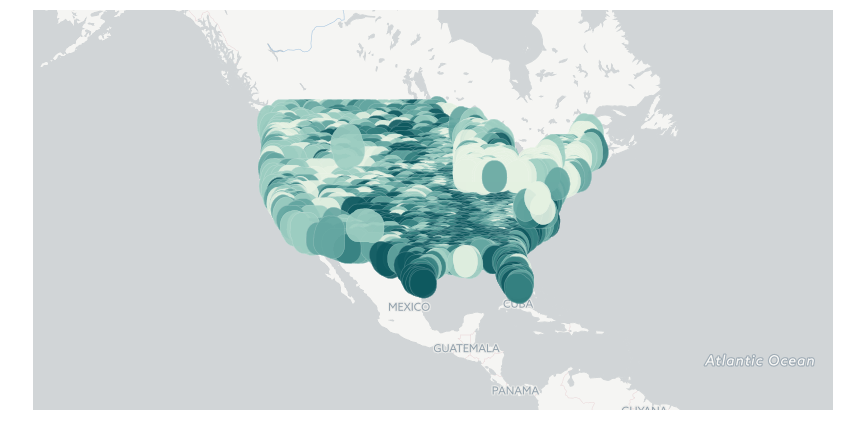

In [16]:
from cartoframes import BaseMap, Layer
cxn.map(layers=[BaseMap('light'),
                Layer('cartoframes_geopandas_buffered', 
                         color='gi69')],
        interactive=False)